# Week 12 Day 1: Requested topic: Fitting

## Objectives:
* Cover probfit and GooFit for general unbinned fitting.

Remember to `pip install probfit` (`--user` if you are not in a virtual environment)

## Make data

First, we make our data. It's a simple double gaussian with no background.

In [1]:
import probfit
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [2]:
dist = np.hstack([
    np.random.normal(loc=1, scale=2., size=100_000),
    np.random.normal(loc=1, scale=.5, size=100_000)
])

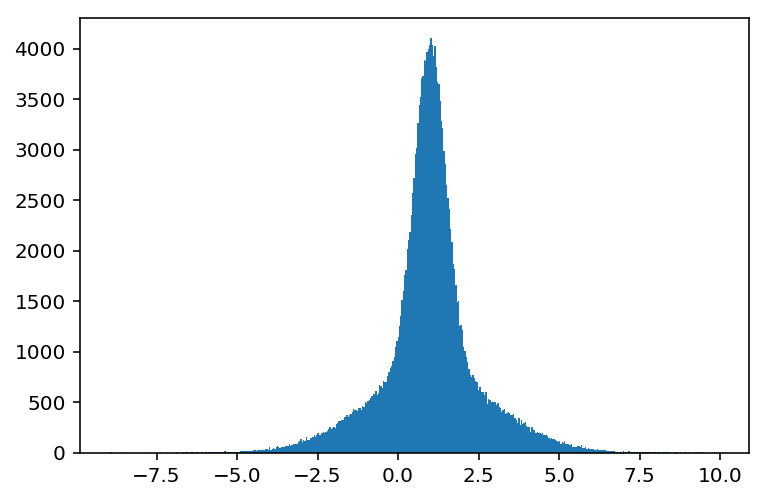

In [3]:
plt.hist(dist, bins='auto');

## Probfit

Now, let's try using probfit to fit the data. First, we have to rename the parameters - probfit merges similar named parameters. I already know that gaussian comes with `x`, `mean`, and `sigma`. We use `AddPdfNorm` to add the pdfs, and they are kept normalized. A new parameter is added, `f_0`.

In [4]:
second_gaussian = probfit.rename(probfit.gaussian, ["x", "mean", "sigma2"])
pdf_function = probfit.AddPdfNorm(probfit.gaussian, second_gaussian)

Now, let's build an unbinned likelyhood function:

In [5]:
unbinned_lh = probfit.UnbinnedLH(pdf_function, dist)

We have to use iMinuit's name based parameter setting interface:

In [6]:
minuit = Minuit(unbinned_lh,
                
                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

And let's do the fit!

In [7]:
%%time
output = minuit.migrad()

FCN = 334777.9515301871 
 TOTAL NCALL = 135 
 NCALLS = 135 
 
 
 EDM = 1.1981415232726732e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mean,0.997266,0.00198641,,,-10,10,No
1,sigma,0.501768,0.00234044,,,0,1,No
2,sigma2,2.005,0.00577768,,,1,3,No
3,f_0,0.501016,0.00241099,,,0,1,No


CPU times: user 40.9 s, sys: 346 ms, total: 41.3 s
Wall time: 41.4 s


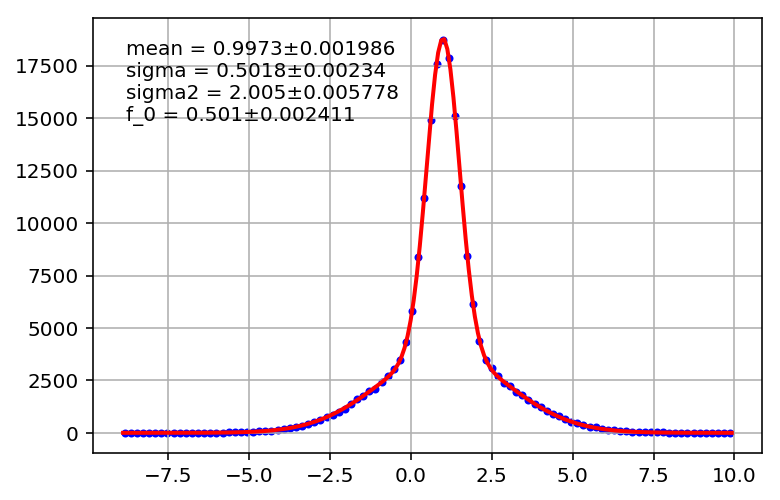

In [8]:
unbinned_lh.draw(minuit);

## GooFit

Let's try that in GooFit. We set up our model in what I view as a more readable but more verbose way:

In [9]:
import goofit

In [10]:
x = goofit.Observable('x', -10, 10)

ds = goofit.UnbinnedDataSet(x)
ds.from_matrix([dist], filter=True)

mean = goofit.Variable('mean', 1.5, -10, 10)
sigma = goofit.Variable('sigma', .4, 0, 1)
sigma2 = goofit.Variable('sigma2', 3, 1, 3)
f_0 = goofit.Variable('f_0', .5, 0, 1)

gauss1 = goofit.GaussianPdf("gauss1", x, mean, sigma)
gauss2 = goofit.GaussianPdf("gauss2", x, mean, sigma2)

pdf = goofit.AddPdf('pdf', [f_0], [gauss1, gauss2])

pdf.fitTo(ds);

MnSeedGenerator: for initial parameters FCN = 775737.3067006
MnSeedGenerator: Initial state:   - FCN =   775737.3067006 Edm =       150665 NCalls =     19
MnSeedGenerator: Negative G2 found - new state:   - FCN =   746485.1464323 Edm =       141912 NCalls =     40
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   746485.1464323 Edm =       141912 NCalls =     40
VariableMetric: Iteration #   0 - FCN =   746485.1464323 Edm =       141912 NCalls =     40
VariableMetric: Iteration #   1 - FCN =   674019.0440008 Edm =      4013.48 NCalls =     52
VariableMetric: Iteration #   2 - FCN =   670554.7601476 Edm =      636.614 NCalls =     61
VariableMetric: Iteration #   3 - FCN =   669626.3606432 Edm =      21.2131 NCalls =     71
VariableMetric: Iteration #   4 - FCN =   669580.2388848 Edm =      13.1833 NCalls =     81
VariableMetric: Iteration #   5 - FCN =   669556.1620087 Edm =     0.249413 NCalls =     91
VariableMetric: Iteration #   6 - FCN

Plotting is a bit more verbose, but not too bad:

In [11]:
grid, points = pdf.evaluatePdf(x)
xs = grid.to_matrix().flatten()

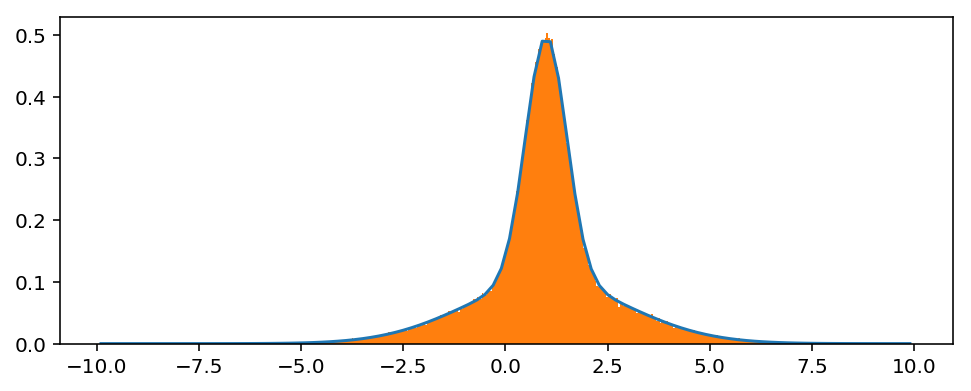

In [12]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xs, points)
ax.hist(dist, bins='auto', density=True)
plt.show()

## Numpy

Let's try this with Numpy and iMinuit. We could use probfit to make the NLL, but it's much faster to do it ourselves.

#### Note:
I originally used numba here, but since this is all done in array form, even parallel Numba is only a small fraction (10-30%) faster. I'm using Anaconda, so I get the MKL numba libraries.

In [13]:
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

In [14]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [15]:
def nll(f_0, mean, sigma, sigma2):
    return -np.sum(np.log(add(dist, f_0, mean, sigma, sigma2)))

In [16]:
nll(.5,.5,.5,.5)

998289.4017408232

In [17]:
%%timeit
nll(.5,.5,.5,.5)

3.06 ms ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
minuit = Minuit(nll,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/Users/henryiii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


I'm not sure where that errordef warning is coming from.

In [20]:
%%time
output = minuit.migrad()

FCN = 334777.95153017854 
 TOTAL NCALL = 135 
 NCALLS = 135 
 
 
 EDM = 1.1948432773322287e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.501016,0.00340964,,,0,1,No
1,mean,0.997266,0.00280921,,,-10,10,No
2,sigma,0.501768,0.00330986,,,0,1,No
3,sigma2,2.005,0.00817082,,,1,3,No


CPU times: user 847 ms, sys: 12.3 ms, total: 859 ms
Wall time: 436 ms


In [18]:
# Much (2-3x) slower if we use this in Minuit
unbinned_lh = probfit.UnbinnedLH(add, dist)

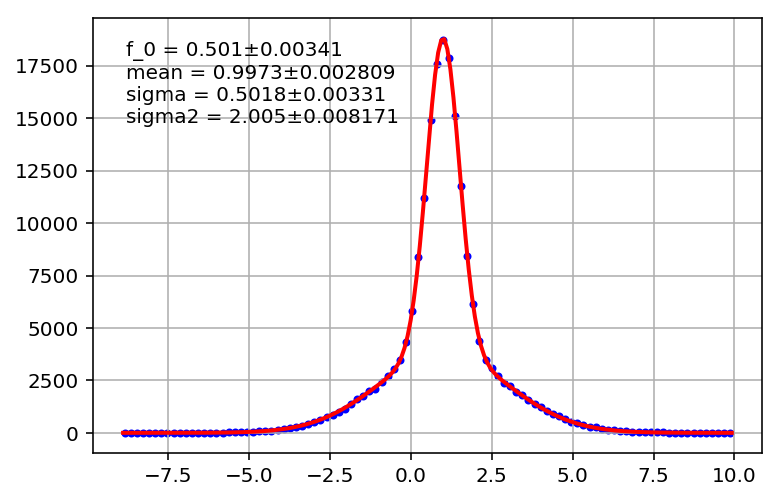

In [21]:
unbinned_lh.draw(minuit);